In [1]:
!nvidia-smi

Wed Aug 12 00:08:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 920MX       Off  | 00000000:03:00.0 Off |                  N/A |
| N/A   40C    P0    N/A /  N/A |      5MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# !git clone https://github.com/ShivamShrirao/dnn_from_scratch.git

In [3]:
# !git clone https://github.com/ShivamShrirao/deep_Q_learning.git

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# %cd deep_Q_learning

In [3]:
import gym
import time
import cv2
import numpy as np

from settings import *
from agent import *
from experience import *
from atari_wrappers import *

In [4]:
env = gym.make('Pong-v0')
env = FrameStack(env, NFRAMES)

In [5]:
# agt = Agent(actions=[0,2,3], epsilon=1, min_epsilon=0.1, eps_decay=1e-5)
# D_exp = ReplayMemory(capacity=100000)

In [6]:
observation = env.reset()

In [7]:
next_observation, reward, done, info = env.step(2)

In [8]:
env.observation_space

Box(210, 160, 4)

In [9]:
next_observation[:].shape

(80, 80, 4)

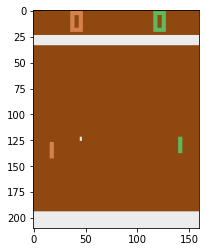

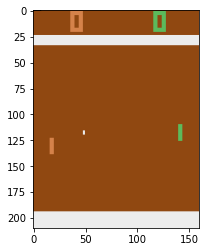

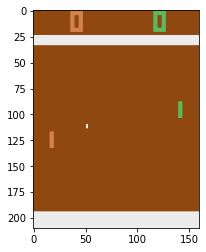

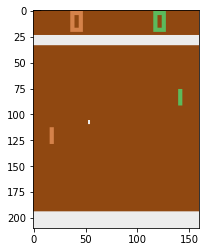

In [102]:
for i in range(0,NFRAMES*3,3):
    plt.imshow(next_observation[:,:,i:i+3])
    plt.show()

In [ ]:
def preprocess_observation(observation):
    state = observation[34:194:2,::2] # 80,80,3
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    # state = cv2.resize(state, (HEIGHT,WIDTH), interpolation = cv2.INTER_NEAREST)
    return state

In [ ]:
for i_episode in range(2000):
    observation = env.reset()
    ep_score = 0
    start = time.time()
    for t in range(10000):
        # env.render()
        action = agt.get_action(stacked_state)
        next_observation, reward, done, info = env.step(action)
        ep_score += reward
        observation = next_observation
#         D_exp.store_transition(stacked_state, action, reward, stacked_next, done)

#         if D_exp.len > BATCH_SIZE:
#             agt.train(D_exp)
        
        if done:
            break
        print('\r', t, ep_score, end='  ')
    print(f"\nEpisode {i_episode} finished after {t+1} timesteps, Score: {ep_score}, Epsilon: {agt.epsilon}, Time: {time.time()-start}")
#     agt.model.save_weights("model.w8s")
env.close()

In [ ]:
for i_episode in range(2000):
    stacked_state = np.zeros((NFRAMES,HEIGHT,WIDTH), dtype=np.uint8)
    stacked_next = np.zeros_like(stacked_state)
    observation = env.reset()
    state = preprocess_observation(observation)
    stacked_next[:3] = stacked_next[1:]
    stacked_next[3] = state
    ep_score = 0
    start = time.time()
    for t in range(10000):
        # env.render()
        stacked_state[:] = stacked_next         # copy values of now current state
        action = agt.get_action(stacked_state)
        next_observation, reward, done, info = env.step(action)
        ep_score += reward
        observation = next_observation

        state = preprocess_observation(observation)
        stacked_next[:3] = stacked_next[1:]         # REMOVE OVERLAPPED
        stacked_next[3] = state

        D_exp.store_transition(stacked_state, action, reward, stacked_next, done)

        if D_exp.len > BATCH_SIZE:
            agt.train(D_exp)
        
        if done:
            break
        print('\r', t, ep_score, end='  ')
    print(f"\nEpisode {i_episode} finished after {t+1} timesteps, Score: {ep_score}, Epsilon: {agt.epsilon}, Time: {time.time()-start}")
    agt.model.save_weights("/content/drive/My Drive/model.w8s")

env.close()

 1153 -19.0  
Episode 0 finished after 1155 timesteps, Score: -20.0, Epsilon: 0.3819900000021575, Time: 35.67261624336243
 1101 -20.0  
Episode 1 finished after 1103 timesteps, Score: -21.0, Epsilon: 0.37096000000214646, Time: 34.00590896606445
 1342 -20.0  
Episode 2 finished after 1344 timesteps, Score: -21.0, Epsilon: 0.357520000002133, Time: 41.404834032058716
 1089 -20.0  
Episode 3 finished after 1091 timesteps, Score: -21.0, Epsilon: 0.3466100000021221, Time: 33.7327766418457
 1105 -20.0  
Episode 4 finished after 1107 timesteps, Score: -21.0, Epsilon: 0.33554000000211104, Time: 34.202162742614746
 1187 -20.0  
Episode 5 finished after 1189 timesteps, Score: -21.0, Epsilon: 0.32365000000209915, Time: 36.87548804283142
 1338 -20.0  
Episode 6 finished after 1340 timesteps, Score: -21.0, Epsilon: 0.31025000000208575, Time: 41.487553358078
 1173 -20.0  
Episode 7 finished after 1175 timesteps, Score: -21.0, Epsilon: 0.298500000002074, Time: 36.51500368118286
 1241 -19.0  
Episode 8

KeyboardInterrupt: ignored